# Text classification using `GloVe` and `sklearn.svm.SVC`


In [2]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive/')

    PROJECT_PATH = "/content/gdrive/MyDrive/WID3002 Natural Language Processing"

    import sys
    sys.path.append(f"{PROJECT_PATH}")
    
    !pip install --upgrade gensim -q
    !pip install wordcloud
except:
    PROJECT_PATH = "."


data_path = f"{PROJECT_PATH}/data/atis_intents_train.csv"
test_file = f"{PROJECT_PATH}/data/atis_intents_test.csv"
dump_path = f"{PROJECT_PATH}/models/svm_model.sav"
load_dump_path = f"{PROJECT_PATH}/models/svm_model.sav"
    
    
import gensim
import pickle
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tqdm import *

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from utils import *

import joblib

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
np.random.seed(42)

In [3]:
import gensim.downloader as api
[print(x) for x in list(gensim.downloader.info()['models'].keys())];

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


## Loading train set and data cleaning

In [5]:
df = load_data(data_path)

In [6]:
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['category'])

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


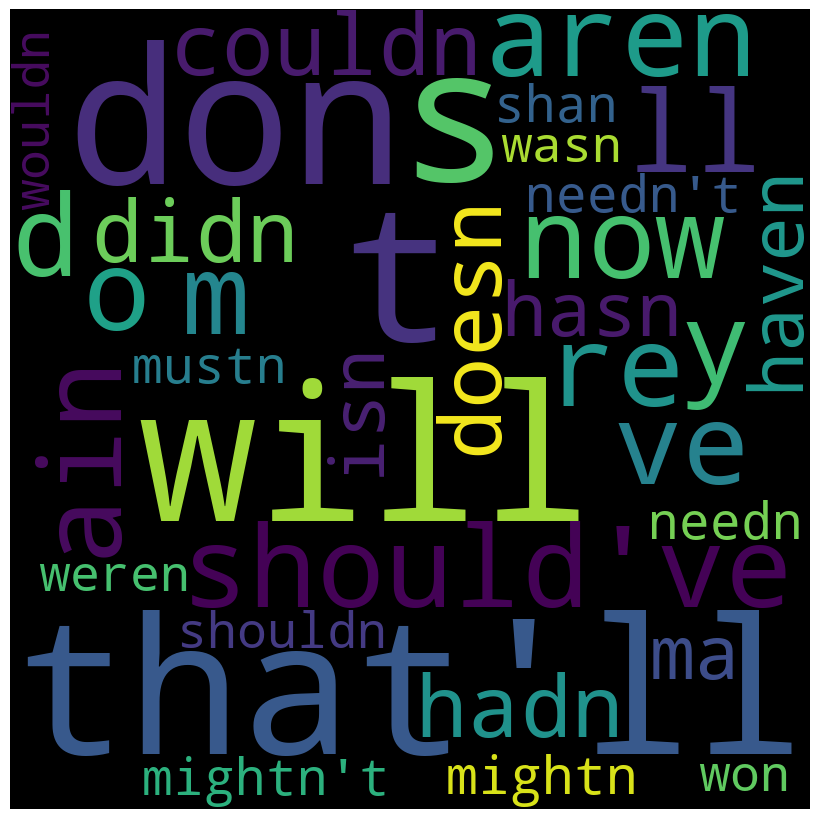

In [7]:
word_cloud = WordCloud(width=800, height=800, background_color='black', min_font_size=10).generate(" ".join(stop_words))
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)

punctuations = string.punctuation
print(punctuations)

In [8]:
df['tokens'] = df['question'].apply(tokenise_sentence)

In [9]:
df['vec'] = df['tokens'].apply(vectorise)

In [10]:
# Preparing dataset
X = df['vec'].to_list()
y = df['category_encoded'].to_list()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
svm_classifier = SVC(kernel='linear', probability=True)

In [12]:
num_epochs = 100

for epoch in tqdm(range(num_epochs)): 
  svm_classifier.fit(X_train, y_train)

100%|██████████| 100/100 [02:03<00:00,  1.24s/it]


In [13]:
# Predict the labels for test data
y_pred = svm_classifier.predict(X_test)

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
# # Evaluate the accuracy of the classifier
print("SVM Accuracy:", accuracy_score(y_test, y_pred))
print("SVM Precision:", precision_score(y_test, y_pred, average='weighted'))
print("SVM Recall:", recall_score(y_test, y_pred, average='weighted'))

SVM Accuracy: 0.9352941176470588
SVM Precision: 0.9144378493478839
SVM Recall: 0.9352941176470588


C:\Users\user\miniconda3\envs\nlp-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Inferencing

In [15]:
infer = "list type of aircraft for all flights from charlotte"
vector = [vectorise(tokenise_sentence(infer))]

In [16]:
pred = svm_classifier.predict(vector)
print(label_encoder.inverse_transform(pred))

['atis_aircraft']


### Testing out the model with test data

In [17]:
test_df = pd.read_csv(test_file, header=None)
test_df.columns = ['category', 'question']
test_df = test_df[~test_df.duplicated(subset='question', keep=False)]

test_df['tokens'] = test_df['question'].apply(tokenise_sentence)
test_df['vec'] = test_df['tokens'].apply(vectorise)

In [18]:
X = df['vec'].to_list()
y = df['category_encoded'].to_list()

In [19]:
y_test_pred = svm_classifier.predict(X)

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
# # Evaluate the accuracy of the classifier
print("SVM Accuracy:", accuracy_score(y, y_test_pred))
print("SVM Precision:", precision_score(y, y_test_pred, average='weighted'))
print("SVM Recall:", recall_score(y, y_test_pred, average='weighted'))

SVM Accuracy: 0.9265882352941176
SVM Precision: 0.9044242222579016
SVM Recall: 0.9265882352941176


C:\Users\user\miniconda3\envs\nlp-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Save and Load trained model

In [21]:
joblib.dump(svm_classifier, dump_path)

['./models/svm_model.sav']

In [22]:
loaded_model = joblib.load(load_dump_path)

In [23]:
infer_loaded = "What is the flight fare"
vector_loaded = [vectorise(tokenise_sentence(infer))]
pred_loaded = loaded_model.predict(vector_loaded)
print(label_encoder.inverse_transform(pred_loaded))

['atis_aircraft']


In [24]:
print(loaded_model.predict_proba(vector_loaded))

[[0.01396136 0.65417445 0.01729435 0.09019494 0.11698472 0.01015042
  0.01621939 0.08102037]]


In [25]:
np.argmax(loaded_model.predict_proba(vector_loaded))

1

In [26]:
pred_probabilities = loaded_model.predict_proba(vector_loaded).flatten()
max_index = np.argmax(pred_probabilities)
pred_prob = pred_probabilities[max_index]
pred_prob
# pred_probabilities

0.6541744520882222